# Brainstation Capstone: UNET Model Final Training & Testing

##### This model will be trained to detect cracks in concrete structures

Explanation: This notebook was created due to learning more about tuning methodology. The previous notebook "UNET_Model.ipynb" was getting too long and featured inconsistent methodology. This notebook will continue with the tuning that the previous notebook made, and will fine-tune the UNET model and test it for production

## Before Starting

### Requirements

In [1]:
# Tensorflow == 2.10.0 is selected to work with CUDA 11.2. Adjust version to be compatible with your CUDA version if available

import importlib
import sys

!pip install matplotlib
print ('Package Installed: matplotlib')
package_list = ['scipy', 'plotly', 'threadpoolctl', 'tensorflow==2.10.0', 'pydot', 'pandas', 'opencv-python', 'tqdm', 'seaborn']

for package in package_list:
    try:
        importlib.import_module(package)
        print(f'Package already installed: {package}')
    except ImportError:
        !{sys.executable} -m pip install {package}
        print(f'Package installed: {package}')

Package Installed: matplotlib
Package already installed: scipy
Package already installed: plotly
Package already installed: threadpoolctl
Package installed: tensorflow==2.10.0
Package already installed: pydot
Package already installed: pandas
Package installed: opencv-python
Package already installed: tqdm
Package already installed: seaborn


In [212]:
import numpy as np
import pandas as pd

import cv2
import os
from PIL import Image
from pathlib import Path
import random

import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf

# Make sure we don't get any GPU errors
print("Built with CUDA: ", tf.test.is_built_with_cuda())
print("Built with GPU support: ", tf.test.is_built_with_gpu_support())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.keras.metrics import Recall, Precision
from keras import backend as K # F1 Score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.utils import plot_model

Built with CUDA:  True
Built with GPU support:  True
Num GPUs Available:  1


### Directories

In [3]:
# To make directories easily editable
HOME = os.getcwd()

print("Home:", HOME)

# If different directory:
Data_Home = r'C:\Users\sepeh\OneDrive\Documents\Data'
print(f'Data_Home: {Data_Home}')

#.csv path
Save_Path = r'C:\Users\sepeh\OneDrive\Documents\Data\DataFrames'
print(f'Dataframe Save_Path: {Save_Path}')

# Folder where resized images are
save_path_256 = os.path.join(Save_Path, 'Resized_256')
save_path_64 = os.path.join(Save_Path, 'Resized_64')

print(f'save_path_256: {save_path_256}')
print(f'save_path_64: {save_path_64}')

# Log directory path
log_dir = os.path.join(Data_Home, 'logs', 'train')

# Create log directory if it doesn't exist
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

print(f'Log Directory: {log_dir}')

Home: \\sepehrnas\Thick Volume\CAREER\SEPEHR\EDUCATION\Brainstation\Data Science\Deliverables\Capstone\segment_anything
Data_Home: C:\Users\sepeh\OneDrive\Documents\Data
Dataframe Save_Path: C:\Users\sepeh\OneDrive\Documents\Data\DataFrames
save_path_256: C:\Users\sepeh\OneDrive\Documents\Data\DataFrames\Resized_256
save_path_64: C:\Users\sepeh\OneDrive\Documents\Data\DataFrames\Resized_64
Log Directory: C:\Users\sepeh\OneDrive\Documents\Data\logs\train


### Random Seed

In [4]:
# ensure model has the same reproducible from training and testing

os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)
random_state = int(42)

## Preparing Data

### Importing Data

Note: This data was created and saved from "UNET_Model.ipynb"

In [5]:
# Importing DataFrames

df_256 = pd.read_csv(os.path.join(save_path_256, 'df_256.csv')).reset_index(drop = True)
df_64 = pd.read_csv(os.path.join(save_path_64, 'df_64.csv')).reset_index(drop = True)

In [6]:
# Shuffling data

df_256 = df_256.sample(frac=1.0, random_state = 1).reset_index(drop=True)
df_64 = df_64.sample(frac=1.0, random_state = 1).reset_index(drop=True)

# Recreating positive/negative dataframes
df_256_positive = df_256[df_256['Label']=='POSITIVE'].reset_index(drop = True)
df_256_negative = df_256[df_256['Label']=='NEGATIVE'].reset_index(drop = True)
df_64_positive = df_64[df_64['Label']=='POSITIVE'].reset_index(drop = True)
df_64_negative = df_64[df_64['Label']=='NEGATIVE'].reset_index(drop = True)

# Verify
df_256_positive

Image_File_Path  Img_Height   
0      C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256  \
1      C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256   
2      C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256   
3      C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256   
4      C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256   
...                                                  ...         ...   
32635  C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256   
32636  C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256   
32637  C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256   
32638  C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256   
32639  C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256   

       Img_Width  Img_AR                                     Mask_File_Path   
0            256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...  \
1            256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
2            256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
3            256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
4            256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
...          ...     ...                                                ...   
32635        256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
32636        256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
32637        256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
32638        256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
32639        256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   

       Mask_Height  Mask_Width  Mask_AR     Label  
0              256         256        1  POSITIVE  
1              256         256        1  POSITIVE  
2              256         256        1  POSITIVE  
3              256         256        1  POSITIVE  
4              256         256        1  POSITIVE  
...            ...         ...      ...       ...  
32635          256         256        1  POSITIVE  
32636          256         256        1  POSITIVE  
32637          256         256        1  POSITIVE  
32638          256         256        1  POSITIVE  
32639          256         256        1  POSITIVE  

[32640 rows x 9 columns]

### Test-Val-Train Splits

In [430]:
# Input of 256x256 images

# sampling size
sample_ratio = 0.99
sample_size = int(len(df_256_positive) * sample_ratio)

# sampling
df_256_positive_sample, df_256_remainder = train_test_split(
    df_256_positive,
    test_size=(1 - sample_ratio),
    # stratify=df_256_positive['Label'],
    shuffle=True,
    random_state=random_state
)

# train/validation and test set
df_256_positive_train_val, df_256_positive_test = train_test_split(
    df_256_positive_sample,
    test_size=0.15,
    # stratify=df_256_positive_sample['Label'],
    shuffle=True,
    random_state=random_state
)

# train and val set
df_256_positive_train, df_256_positive_val = train_test_split(
    df_256_positive_train_val,
    test_size=0.15,
    # stratify=df_256_positive_train_val['Label'],
    shuffle=True,
    random_state=random_state
)

# Removing unnecessary features to decrease potential computational demand. 
drop_columns = ['Img_Height', 'Img_Width', 'Img_AR', 'Mask_Height', 'Mask_Width', 'Mask_AR', 'Label']
df_256_positive_train = df_256_positive_train.drop(df_256_positive_train[drop_columns], axis = 1)
df_256_positive_val = df_256_positive_val.drop(df_256_positive_val[drop_columns], axis = 1)
df_256_positive_test = df_256_positive_test.drop(df_256_positive_test[drop_columns], axis = 1)

# Verify
print(f'Original size: {df_256_positive.shape[0]}')
print(f'Sampled at {sample_ratio}')
print(f'Train size: {df_256_positive_train.shape[0]} ({df_256_positive_train.shape[0]/df_256_positive.shape[0]:0.2f}%)')
print(f'Validation size: {df_256_positive_val.shape[0]} ({df_256_positive_val.shape[0]/df_256_positive.shape[0]:0.2f}%)')
print(f'Test size: {df_256_positive_test.shape[0]} ({df_256_positive_test.shape[0]/df_256_positive.shape[0]:02f}%)')
df_256_positive_train.head(2)

Original size: 32640
Sampled at 0.99
Train size: 23346 (0.72%)
Validation size: 4120 (0.13%)
Test size: 4847 (0.148499%)


Image_File_Path   
30959  C:\Users\sepeh\OneDrive\Documents\Data\Concret...  \
5409   C:\Users\sepeh\OneDrive\Documents\Data\Concret...   

                                          Mask_File_Path  
30959  C:\Users\sepeh\OneDrive\Documents\Data\Concret...  
5409   C:\Users\sepeh\OneDrive\Documents\Data\Concret...

## Pre-Training Explanations

### Model Selection Explanation

As explained in the previous notebook, "UNET_Model.ipynb", 

UNET is chosen for its popularity for its effective architecture for image segmenmtation tasks, including masking of concrete cracks. Its 5 major benefits are:

1) It has encoder-decoder architecture, which captures local and global features, making it suitable for concrete crack masking
2) The skip connections in UNet retain spatial information, enabling it to recover fine details and address information loss during downsampling.
3) The U-shape design of UNet allows for learning hierarchical representations at different scales, aiding accurate localization and precise segmentation of concrete cracks.
4) Net effectively fuses features from different levels, enabling it to handle variations in crack size, shape, and texture.
5) UNet performs well with limited training data, making it suitable for concrete crack segmentation even when the labeled dataset is limited.

Its flow diagram can be seen below

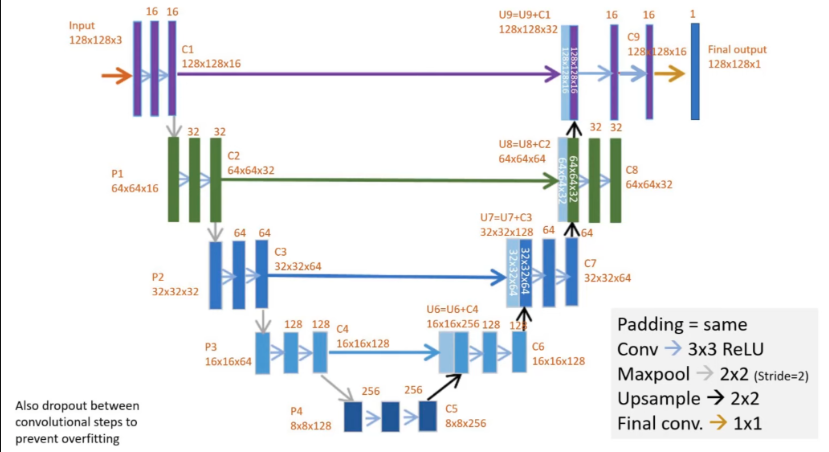

### Parameter Selection Summary

Activation Function: ReLu will be used initially due to established popularity. Sigmoid will be used as final output due to its property of mapping any input to a range of 0,1, which is required for mask prediction. Leaky ReLu will be tested to see if there's improvements

Kernel Initializer: he_normal will be used sine most applicable with ReLu. HeUniform will be tested as well.

Optimizer: Adam will be selected because it combines benfits of stochastic gradient descent AdaGrad and RMSProp, is computationally efficient, and has little memory requirement. Other optimizers that can be tested are RMSprop and SGD with momentum.

Loss Function: Weighted/Regular Crossboundary will be used due to the nature of the problem. By increasing weight of positive data (crack pixels), it programs the model to value positive data more

Performance Metric: F1 score will be used in conjuction to recall. Recall is important because it is costly to miss a crack. IoU will be tracked as well for pixel comparison. A good score for IoU would be >0.7



*Note: A more extensive explanation is avaialble in the previous notebook, 'UNET_Model.ipynb'*

### Tuning Methodology

Train Loss and Validation loss will be compared with the listed parameter changes to determine overfitting/underfitting and performance. In addition, the IoU, Recall, and F1 scores will be compared.

- Image Size: 64x64 will no longer be tested. Only 256x256
- Sample size: Will remain at a constant 10% so train data doesn't get mixed. Once paramets are hypertuned, will set to 100% for final training
- Batch Size: Due to GPU restrictions, will be set between 10 and 40
- Weights of Binomial Cross Entropy: Will be experimented from ranges of 0.1 to 2.0
- Epoch: Will be set to a large number and try to stay consistent. The number of epochs will be limited by an Early Stopping function that will stop the training based on validation loss 
- Learning Rate: Will change based on number of epochs and experimented between 0.0001 to 0.1
- CNN Layers: Most likely 5 layers is ideal due to simplicity of crack detection. But will start at 7 and move down to 5 and check performance.
- CNN Kernels: Whichever model layer performance is proven to be best for performance, number of kernels will be tested on. Most likely (3,3) is ideal due to simplicity of crack detection, but (5,5) will be tested
- Kernel Initializer: he_normal and he_uniform will be tested
- Optimizer: Adam, RMSprop, and SGD with momentum will be tested
- Activation Function: ReLu with loss will be tested (important to test on both validation and test set)

## Building Model

### Creating Loss Function and Scoring Metrics

In [432]:
def weighted_binary_crossentropy(y_true, y_pred):
    
    """
    Weighted binary crossentropy between an output tenso and target tensor 

    Args:
      y_true: A binary tensor of shape (batch_size, num_pixels, 1) 
        as ground truth labels.
      y_pred: A binary tensor of shape (batch_size, num_pixels, 1) 
        as predicted labels.

    Returns:
      A scalar tensor as loss.
    """
    
    # will feed into df_history
    global negative_weight, positive_weight
   
    # 1 on each will give standard binary crossentrop    
    negative_weight = float(0.9) 
    positive_weight = float(1.1)
   
    
    class_weights = tf.constant([negative_weight, positive_weight])

    # Use TensorFlow's binary crossentropy function
    b_ce = tf.keras.losses.BinaryCrossentropy()

    # Calculate the binary crossentropy
    b_ce_loss = b_ce(y_true, y_pred)

    # Apply the weights
    weights = (y_true * class_weights[1]) + ((1. - y_true) * class_weights[0])
    weighted_loss = weights * b_ce_loss

    # Return the mean loss
    return tf.reduce_mean(weighted_loss)
  
  
  
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
  
# Intersection-Over-Union (IoU), or Jaccard Index
def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)


### U-Net 5 Layers

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_4 (Lambda)              (None, 256, 256, 3)  0           ['input_layer[0][0]']            
                                                                                                  
 conv2d_92 (Conv2D)             (None, 256, 256, 16  448         ['lambda_4[0][0]']               
                                )                                                                 
                                                                                            

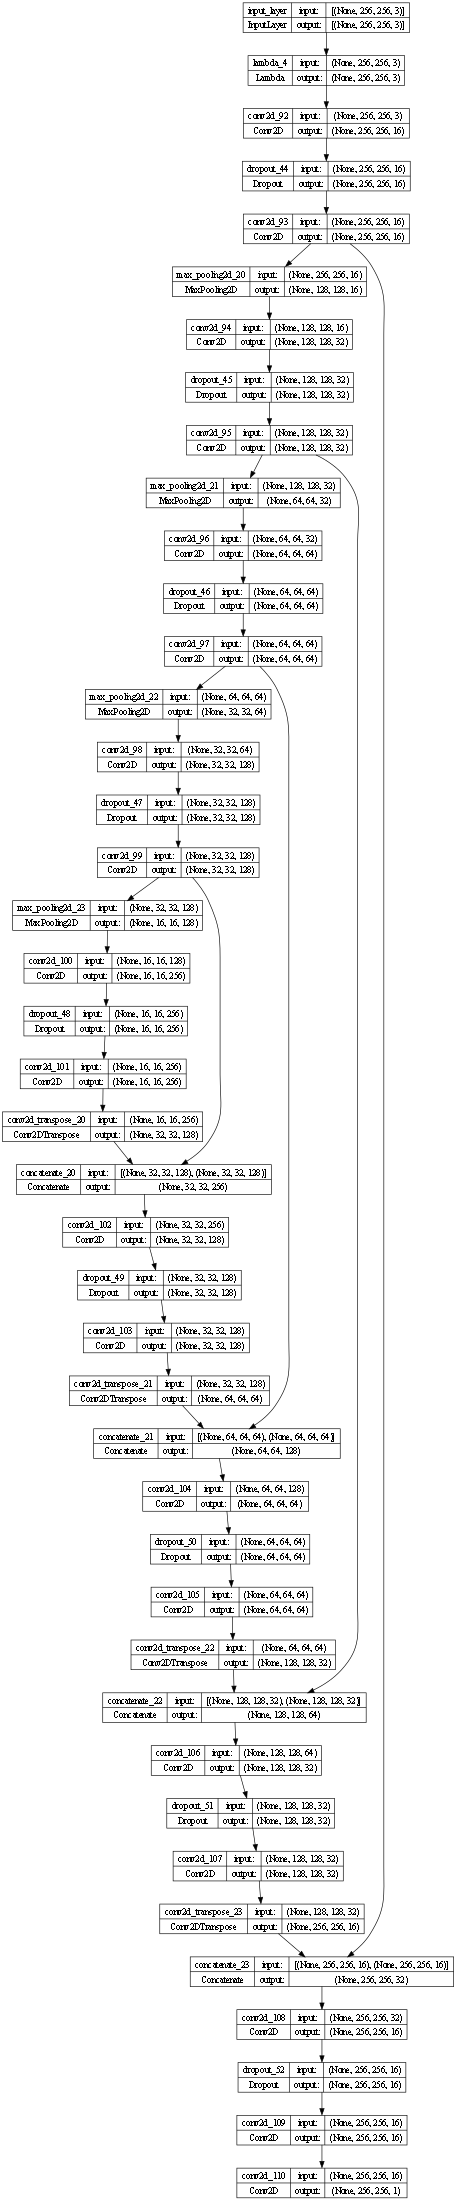

In [51]:
"""""

UNET Model with 5 layers.

Each layer halves the image width and height pixels

Imput image properties and parameters below

"""

# Will feed into df_history
global IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, activation_function 
global kernel_initializer, optimizer, learning_rate, loss_function_str

# Image properties
IMG_WIDTH = int(256)
IMG_HEIGHT = int(256)

IMG_CHANNELS = int(3) #(RGB)

# Input Layer
inputs = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), name='input_layer')

# activation function 
# Relu is chosen for its simplicity
activation_function = 'relu'

# Starting weights (UNET iteratively improves this)
kernel_initializer = 'he_normal'

# padding = same due to model requirement
padding = 'same'

# Learning rate & Optimizer
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# loss function used to optimize
loss_function = weighted_binary_crossentropy
loss_function_str = "weighted_binary_crossentropy"

# This is the regular python lambda function
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

# Convolution layers

# Contraction Path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c5)

# Expansive Path
u6 = tf.keras.layers.Conv2DTranspose(128,(2,2), strides = (2,2), padding = padding)(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c6)

u7 = tf.keras.layers.Conv2DTranspose(64,(2,2), strides = (2,2), padding = padding)(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c7)

u8 = tf.keras.layers.Conv2DTranspose(32,(2,2), strides = (2,2), padding = padding)(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c8)

u9 = tf.keras.layers.Conv2DTranspose(16,(2,2), strides = (2,2), padding = padding)(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c9)

# Output Layer
outputs = tf.keras.layers.Conv2D(1,(1,1), activation = 'sigmoid')(c9)

unet = tf.keras.Model(inputs = [inputs], outputs = [outputs])
history = unet.compile(
   optimizer=optimizer,
   loss= loss_function,
   metrics=[f1_score, iou_coef, tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), 'accuracy']
   )
unet.summary()

# plot
tf.keras.utils.plot_model(unet, "unet.png", show_shapes = True, dpi = 45)

### U-Net 6 Layers

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_22 (Lambda)             (None, 256, 256, 3)  0           ['input_layer[0][0]']            
                                                                                                  
 conv2d_502 (Conv2D)            (None, 256, 256, 16  448         ['lambda_22[0][0]']              
                                )                                                                 
                                                                                           

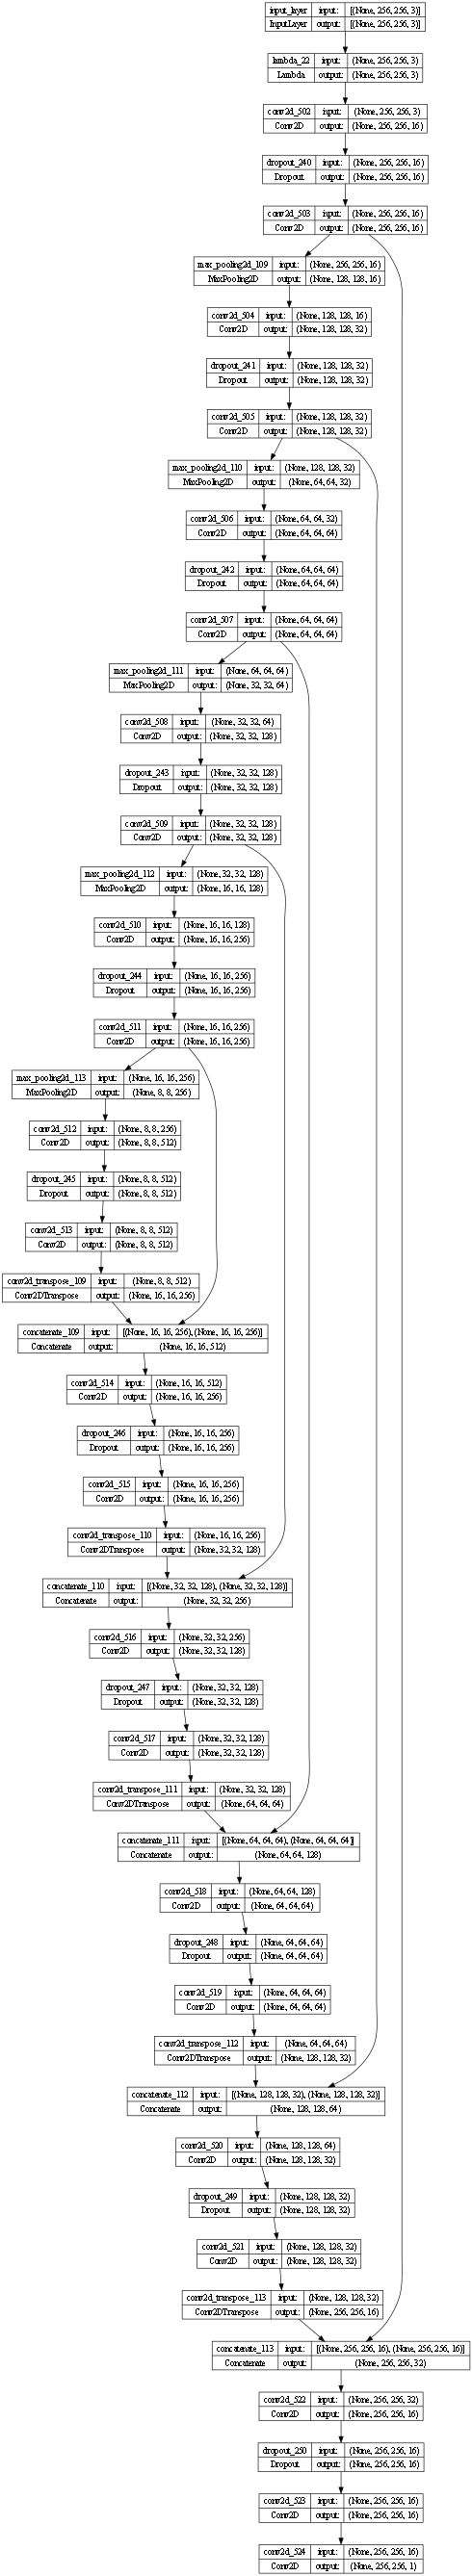

In [375]:
"""""

UNET Model with 6 layers.

Each layer halves the image width and height pixels

Imput image properties and parameters below

"""

# Will feed into df_history
global IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, activation_function 
global kernel_initializer, optimizer, learning_rate, loss_function_str

# Image properties
IMG_WIDTH = int(256)
IMG_HEIGHT = int(256)

IMG_CHANNELS = int(3) #(RGB)

# Input Layer
inputs = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), name='input_layer')

# activation function 
# Instantiate LeakyReLU #if 0, regular ReLu. ReLu chosen for simplicity
leaky_relu = LeakyReLU(alpha=0.375)
activation_function = 'leaky_relu'

# Starting weights (UNET iteratively improves this)
kernel_initializer = 'he_normal'

# padding = same due to model requirement
padding = 'same'

# Learning rate & Optimizer
learning_rate = 0.0001
# momentum = 0.9 # typical value for SGD Optimizer momentum is in the range [0.9, 0.99]
optimizer = Adam(learning_rate=learning_rate
               #   , momentum=momentum
                 )

# loss function used to optimize
loss_function = weighted_binary_crossentropy
loss_function_str = "weighted_binary_crossentropy"

# This is the regular python lambda function
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

# Convolution layers

# Contraction Path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c5)
p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)

c6 = tf.keras.layers.Conv2D(512, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p5)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(512, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c6)

# Expansive Path
u7 = tf.keras.layers.Conv2DTranspose(256,(2,2), strides = (2,2), padding = padding)(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(256,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c7)

u8 = tf.keras.layers.Conv2DTranspose(128,(2,2), strides = (2,2), padding = padding)(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c8)

u9 = tf.keras.layers.Conv2DTranspose(64,(2,2), strides = (2,2), padding = padding)(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c9)

u10 = tf.keras.layers.Conv2DTranspose(32,(2,2), strides = (2,2), padding = padding)(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(u10)
c10 = tf.keras.layers.Dropout(0.2)(c10)
c10 = tf.keras.layers.Conv2D(32,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c10)

u11 = tf.keras.layers.Conv2DTranspose(16,(2,2), strides = (2,2), padding = padding)(c10)
u11 = tf.keras.layers.concatenate([u11, c1])
c11 = tf.keras.layers.Conv2D(16,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(u11)
c11 = tf.keras.layers.Dropout(0.2)(c11)
c11 = tf.keras.layers.Conv2D(16,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c11)

# Create final output layer
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

unet = tf.keras.Model(inputs = [inputs], outputs = [outputs])
history = unet.compile(
   optimizer=optimizer,
   loss= loss_function,
   metrics=[f1_score, iou_coef, tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), 'accuracy']
   )
unet.summary()

# plot
tf.keras.utils.plot_model(unet, "unet.png", show_shapes = True, dpi = 45)

### U-Net 7 Layers

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_2 (Lambda)              (None, 256, 256, 3)  0           ['input_layer[0][0]']            
                                                                                                  
 conv2d_46 (Conv2D)             (None, 256, 256, 16  448         ['lambda_2[0][0]']               
                                )                                                                 
                                                                                            

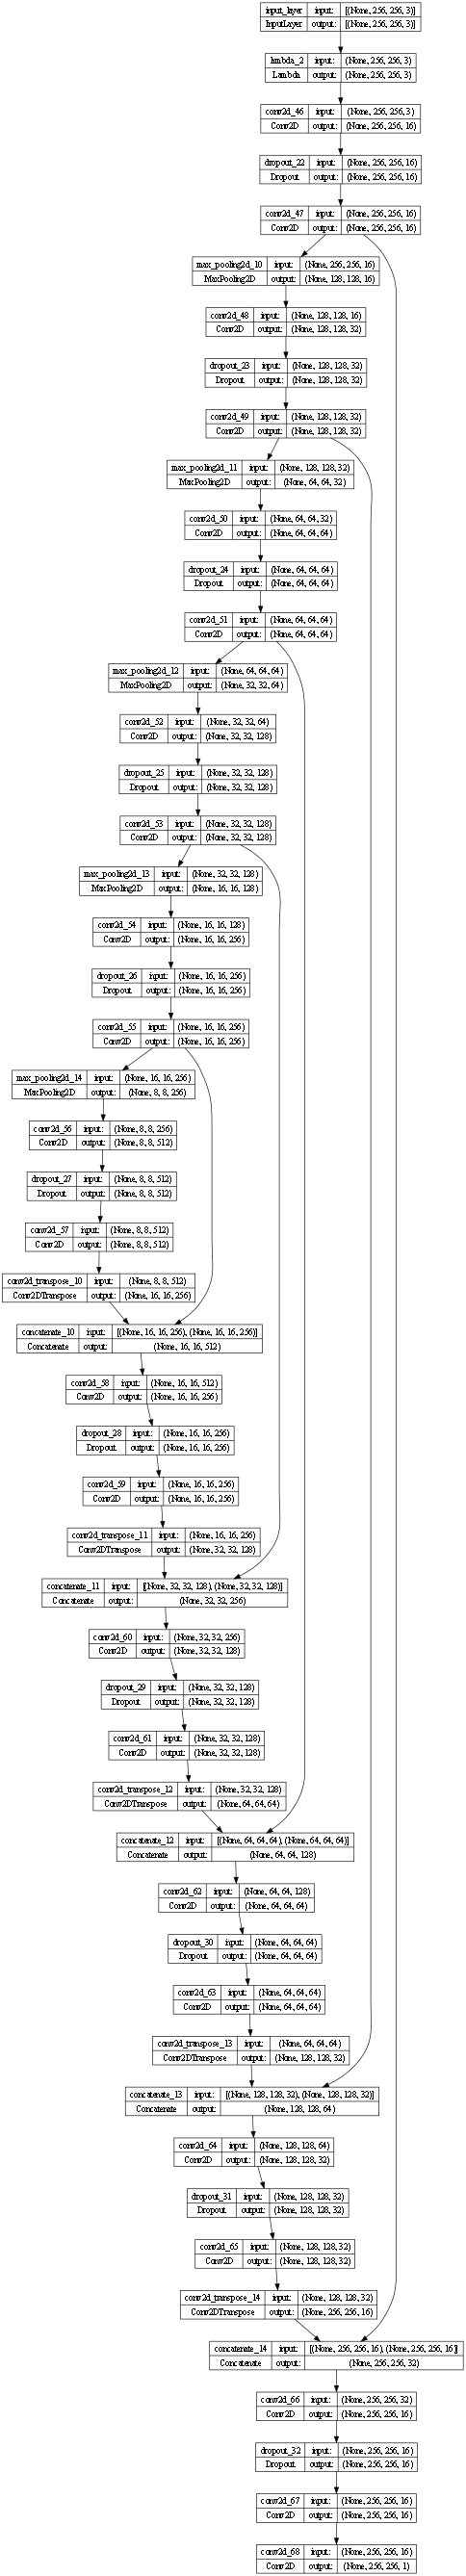

In [18]:
"""""

UNET Model with 7 layers.

Each layer halves the image width and height pixels

Imput image properties and parameters below

"""

# Will feed into df_history
global IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, activation_function 
global kernel_initializer, optimizer, learning_rate, loss_function_str

# Image properties
IMG_WIDTH = int(256)
IMG_HEIGHT = int(256)

IMG_CHANNELS = int(3) #(RGB)

# Input Layer
inputs = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), name='input_layer')

# activation function 
# Relu is chosen for its simplicity
activation_function = 'relu'

# Starting weights (UNET iteratively improves this)
kernel_initializer = 'he_normal'

# padding = same due to model requirement
padding = 'same'

# Learning rate & Optimizer
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# loss function used to optimize
loss_function = weighted_binary_crossentropy
loss_function_str = "weighted_binary_crossentropy"

# This is the regular python lambda function
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

# Convolution layers

# Contraction Path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c5)
p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)

c6 = tf.keras.layers.Conv2D(512, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                            padding=padding)(p5)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                            padding=padding)(c6)

# Expansive Path
u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding=padding)(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                            padding=padding)(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                            padding=padding)(c7)

u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding=padding)(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                            padding=padding)(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                            padding=padding)(c8)

u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding=padding)(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                            padding=padding)(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                            padding=padding)(c9)

u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding=padding)(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                             padding=padding)(u10)
c10 = tf.keras.layers.Dropout(0.2)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                             padding=padding)(c10)

u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding=padding)(c10)
u11 = tf.keras.layers.concatenate([u11, c1])
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                             padding=padding)(u11)
c11 = tf.keras.layers.Dropout(0.2)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                             padding=padding)(c11)

# Create final output layer
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

unet = tf.keras.Model(inputs = [inputs], outputs = [outputs])
history = unet.compile(optimizer=optimizer, loss= loss_function, metrics=[f1_score, iou_coef, tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), 'accuracy'])
unet.summary()

# plot
tf.keras.utils.plot_model(unet, "unet.png", show_shapes = True, dpi = 45)

## Tuning Model

#### Functions to call

In [464]:

# generates images to be used in model

def create_data_generator(dataframe, batch_size, shuffle = True):
    while True:
        # Select the indices for a single batch of data
        indices = np.random.choice(dataframe.shape[0], batch_size)
        
        image_batch = []
        mask_batch = []

        for index in indices:
            image_path = dataframe.loc[index, 'Image_File_Path']
            mask_path = dataframe.loc[index, 'Mask_File_Path']

            # Load the image, convert to rgb if applicable, normalize pixel values
            image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) / 255.0
            # Load the mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 

            # Convert Greyscale to Binary
            _, binary_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

            # Normalize binary mask
            binary_mask = binary_mask / 255.0

            image_batch.append(image)
            mask_batch.append(binary_mask)

        yield np.array(image_batch), np.array(mask_batch)
        

# Takes unet.history.history and returns a dataframe with renamed consistent columns for storing

def rename_dataframe_columns(df_history):
    # Convert the history to a DataFrame
    df = pd.DataFrame(df_history)

    # Define a dictionary to map old names to new names
    rename_dict = {}

    # Iterate over the columns in the original DataFrame
    for col in df.columns:
        if 'recall' in col:
            if 'val' in col:
                rename_dict[col] = 'val_recall'
            else:
                rename_dict[col] = 'recall'
        elif 'precision' in col:
            if 'val' in col:
                rename_dict[col] = 'val_precision'
            else:
                rename_dict[col] = 'precision'
        elif 'f1_score' in col:
            if 'val' in col:
                rename_dict[col] = 'val_f1_score'
            else:
                rename_dict[col] = 'f1_score'
        # Add other conditions as needed

    # Rename the columns
    df = df.rename(columns=rename_dict)

    return df

# runs the model and stores information for analysis

def run_model(df_train_selected, df_val_selected, df_test_selected, batch_size = 32, epochs = 15, patience = 3, caption=None):
    
    # count is to record iteration, 
    # df_history is storing model FINAL results
    # def_results is to store tuning parameters and final recall results
    # generators are for plotting outside function\
    # the rest are for backups in case wrangling goes wrong
    
    global count, df_history, df_history_new, df_results_train, train_generator,val_generator, test_generator
    global df_history_final, df_history_backup, df_history_final_backup, df_history_train_backup, df_results_train_backup
        
    
    
       
    # Increase counter
    try:
        count
    except NameError:
      count = 0
    
    count += 1
       
    # Parameters
    batch_size = batch_size
    df_train = df_train_selected.copy().reset_index(drop=True)
    df_val = df_val_selected.copy().reset_index(drop=True)
    df_test = df_test_selected.copy().reset_index(drop=True)

    # Create the data generator
    train_generator = create_data_generator(df_train, batch_size, shuffle = True)
    val_generator = create_data_generator(df_val, batch_size, shuffle = True)
    
    # We want test generator to have 0 shuffle, while train and validation to have shuffle
    test_generator = create_data_generator(df_test, batch_size, shuffle = False)

    # Model Checkpoint directory path
    # checkpoint_filepath = os.path.join(Data_Home, 'Model_Checkpoints', 'Checkpoint')
    checkpoint_filepath = r'C:\Users\sepeh\OneDrive\Downloads'

    # Create if it doesn't exist
    if not os.path.exists(checkpoint_filepath):
        os.makedirs(checkpoint_filepath)

    print(f'Checkpoint Directory: {checkpoint_filepath}')

    # # Initialize the Model Checkpoint callback
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss', # monitors validation loss
        mode='min',
        save_best_only=True)

    # Initialize the Early Stopping callback
    early_stopping_callback = EarlyStopping(
        monitor='val_loss', # monitors validation loss
        mode='min',
        patience=patience, # training will be stopped after set# of epochs (patience) if val_loss doesn't improve
        restore_best_weights=True)

    """ 

    Model.fit

    """
    # Train the U-Net model
    history = unet.fit(train_generator,
                    validation_data=val_generator,
                    steps_per_epoch=len(df_train) // batch_size,
                    validation_steps=len(df_val) // batch_size,
                    epochs=epochs,
                    callbacks=[model_checkpoint_callback, early_stopping_callback]
                    ) 
    # Callback will stop training if val_loss doesn't improve after set # of epochs (patience)
     
    
    # Create df_history if doesn't exist
    try:
        df_history
    except NameError:
        df_history = pd.DataFrame(columns = ["loss", "f1_score", "iou_coef", "recall", "precision", "accuracy", 
                                             "val_loss", "val_f1_score", 'val_iou_coef', "val_recall", "val_precision",
                                             "val_accuracy", "Run #"])
    
    # New history dataframe is crated from unet.history.history results, and renamed using function
    df_history_new = rename_dataframe_columns(unet.history.history)
    
    # Final Epoch Number
    num_epochs_new = len(df_history_new)
    
    # Append count number to df_history_new
    df_count = pd.DataFrame({'Run #': [count] * num_epochs_new})  
    df_history_new = pd.concat([df_history_new, df_count], axis = 1) 
        
    # New history dataframe is appended to existing dataframe
    df_history_new = df_history_new.reindex(columns=df_history.columns, fill_value=0)  
    df_history = pd.concat([df_history, df_history_new], axis=0, ignore_index=True)
    df_history.reset_index(drop=True, inplace=True)
   
    # Final Training Accuracy Score:
    accuracy_score_new = df_history.iloc[-1,5]
    # Final Training Recall Score:
    recall_score_new = df_history.iloc[-1,3]
    # Final Train F1 Score:
    f1_score_new = df_history.iloc[-1,1]
    #  Final IoU Score:
    iou_new = df_history.iloc[-1,2]
    
    # Final Validation Accuracy Score:
    val_accuracy_score_new = df_history.iloc[-1,11]
    # Final Validation Recall Score:
    val_recall_score_new = df_history.iloc[-1,9]
    # Final Validation F1 Score:
    val_f1_score_new = df_history.iloc[-1,7]
    #  Final Validation IoU Score:
    val_iou_new = df_history.iloc[-1,8]
    
    # create df_results the first time to store information
    try:
        df_results_train
    except NameError:
    # Create df
        df_results_train = pd.DataFrame(columns = ["Run #", "Img_Size", "Sample", "Epoch Reached", "Batch", 
                                        "Activation_Function", "Kernel_Initializer", "Optimizer", "Learning_rate", "Loss Function",
                                        "Negative_Weight", "Positive_Weight", "Accuracy Score", "Training Recall Score", 
                                        "Training F1 Score", "Training IoU Score", 'Val Accuracy Score', 
                                        "Val Recall Score", "Val F1 Score", "Val IoU Score","Caption"])

    # Create new row df columns
    df_results_train_new = pd.DataFrame(columns = ["Run #", "Img_Size", "Sample", "Epoch Reached", "Batch", 
                                        "Activation_Function", "Kernel_Initializer", "Optimizer", "Learning_rate", "Loss Function",
                                        "Negative_Weight", "Positive_Weight", "Accuracy Score", "Training Recall Score", 
                                        "Training F1 Score", "Training IoU Score", 'Val Accuracy Score', 
                                        "Val Recall Score", "Val F1 Score", "Val IoU Score","Caption"])


    # Add information to new row df
    df_results_train_new.loc[count-1] = [
                        count, 
                        IMG_WIDTH,
                        sample_ratio, 
                        num_epochs_new,  
                        batch_size,
                        activation_function,  
                        kernel_initializer,  
                        optimizer, 
                        learning_rate,
                        loss_function_str,
                        negative_weight, 
                        positive_weight,
                        accuracy_score_new, 
                        recall_score_new, 
                        f1_score_new,
                        iou_new,
                        val_accuracy_score_new,
                        val_recall_score_new,
                        val_f1_score_new,
                        val_iou_new,
                        caption
                        ]

    df_results_train = pd.concat([df_results_train, df_results_train_new], axis = 0, ignore_index=True)   
    df_history_final = df_history.groupby('Run #').last().reset_index()
    
    # Backups in case something goes wrong with wrangling during tuning
    df_history_backup = df_history.copy()
    df_history_final_backup = df_history_final.copy()
    df_results_train_backup = df_results_train.copy()
    
## Plots predicted images   
def plotImages(images_arr, masks_arr, width = 14, height = 4, hspace = -0.8):
    num_images = len(images_arr) * 2  # Each pair consists of 2 images
    num_cols = 10  # Each pair will occupy 2 columns (one for image, one for mask)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate rows based on images
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(width, height*num_rows), sharex=True, sharey=True)
    
    axes = axes.ravel()  # Flatten axes for easy indexing
    
    for i in range(len(images_arr)):
        axes[2*i].imshow(images_arr[i])
        axes[2*i].axis('off')
        axes[2*i].set_title('Image')
        
        axes[2*i+1].imshow(masks_arr[i], cmap='gray')
        axes[2*i+1].axis('off')
        axes[2*i+1].set_title('Mask')
        
    # Turn off axes for remaining empty subplots
    for j in range(num_images, num_rows*num_cols):
        fig.delaxes(axes[j])
        
    # Adjust the spacing between rows
    plt.subplots_adjust(hspace= hspace)   
    
# Used to split texts into multiple lines for readability
def split_text(text, length):
    return '\n'.join(text[i:i+length] for i in range(0, len(text), length))

# Used to plot validation and train scores and loss
def plot_results (start, end):
    
    # Figure size
    plt.figure(figsize=(17, 9 * end))

    # a counter to mark the plot index
    plot_number = 1 

    # List of columns to plot
    columns_to_plot = [['loss', 'val_loss'], 
                    ['recall','f1_score','val_f1_score', 'val_recall'], 
                    ['iou_coef', 'val_iou_coef']]

    # list of y labels to plot
    y_labels_to_plot = ['Loss', 'Score', 'IoU']

    # List of columns to print the plot
    columns_to_print = ['Training Recall Score', 'Training F1 Score', 'Training IoU Score', 
                        'Val Recall Score', 'Val F1 Score', 'Val IoU Score','Caption']

    for run_number in range(start, end+1):
        
        # Set up row title to plot
        titles_to_plot = ['Model loss for Run #' + str(run_number),
                        'Model Recall and F1 Score for Run #' + str(run_number),
                        'Model IoU for Run #' + str(run_number)]
        
        # Get the metrics data to plot
        df_plot = df_history[df_history['Run #'] == run_number]
        
        # Set x-ticks to represent the number of epochs
        num_of_epochs = df_plot.shape[0]
            
        # Get the row caption data to plot
        run_caption = df_results_train[df_results_train['Run #']==run_number]['Caption'].values[0]
                        
        for i in range(0,3):
        
            # Select the subplot position
            plt.subplot(end, 3,plot_number)
                        
            # Plot columns_to_plot
            y = range(num_of_epochs)
            x = df_plot[columns_to_plot[i]]
            
            plt.plot(y,x)
            plt.title(titles_to_plot[i])
            plt.xlabel('Epoch')
            plt.ylabel(y_labels_to_plot[i])
            plt.legend(x,loc= 'upper left')
            plt.text(0.5,0.8, split_text(run_caption, 60),
                    horizontalalignment = 'center',
                    verticalalignment = 'center',
                    transform=plt.gca().transAxes)
            plt.xticks(range(0,num_of_epochs))
                
                
            if i == 0:
                
                # set yticks and values shown
                plt.yticks(np.arange(0, 0.5, 0.01))
            
            if i == 1:
                
                # set yticks and values shown
                plt.yticks(np.arange(0, 1, 0.025))                   
                    
            if i == 2:
                
                # set yticks and values shown
                plt.yticks(np.arange(0, 1, 0.025))
                        
            # Increase index counter
            plot_number += 1

        ## ONLY ACTIVATES ON MOST RECENT RESULTS
        if end - run_number == 1 :
            
            # Final Loss difference:
            loss_old = df_history[df_history['Run #'] == run_number].iloc[-1][['loss', 'val_loss']]
            loss_new = df_history[df_history['Run #'] == end].iloc[-1][['loss', 'val_loss']]
            loss_difference = loss_new - loss_old
            
             # print the difference between the last two iteration scores
            print(f'Final Training and Val Loss changed by: {loss_difference[0]:0.3f} , {loss_difference[1]:0.3f}\n')
            
            for i in range(0,6):
    
                # scoring metrics difference
                scores_old = df_results_train[df_results_train['Run #'] == run_number][columns_to_print[i]].values[0]
                scores_recent = df_results_train[df_results_train['Run #'] == end][columns_to_print[i]].values[0]
                scores_difference =  scores_recent - scores_old
                    
                print(f'{columns_to_print[i]} changed by: {scores_difference:0.3f}')
                            
            
            # Number of epochs:
            num_epochs = len(df_history[df_history['Run #']==end])
            # Print the number of epochs
            print(f'Number of epochs for Run # {end}: {num_epochs}')

            # Caption for latest results:
                # Get the row caption data to plot
            run_caption_recent = df_results_train[df_results_train['Run #']==end]['Caption'].values[0]
            # Print the caption or comment for the run
            print(f'Comments for Run #{end}: {run_caption_recent}\n')
        
    # Show the plot
    plt.tight_layout(pad=0.1) # padding between subplots
    # plt.subplots_adjust(wspace=0, hspace =0)
    plt.show()
    
## Plot df_history_final against run #
def plot_final_results(df_history_final):
    # Creating a figure with 3 subplots: Loss, F1-score and IoU coefficient
    fig, axs = plt.subplots(3, 1, figsize=(15, 20))

    # Defining x-ticks and x-tick labels
    x_ticks = np.arange(0, len(df_history_final), 1)
    x_labels = [f'Run #{i}' for i in x_ticks]

    # Plot training and validation loss
    axs[0].plot(df_history_final['loss'], label='Training Loss')
    axs[0].plot(df_history_final['val_loss'], label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Run #')
    axs[0].set_ylabel('Loss')
    axs[0].set_xticks(x_ticks)
    axs[0].set_xticklabels(x_labels, rotation=45)
    axs[0].legend()

    # Plot F1-score and validation F1-score
    axs[1].plot(df_history_final['f1_score'], label='Training F1 Score')
    axs[1].plot(df_history_final['val_f1_score'], label='Validation F1 Score')
    axs[1].set_title('Training and Validation F1 Score')
    axs[1].set_xlabel('Run #')
    axs[1].set_ylabel('F1 Score')
    axs[1].set_xticks(x_ticks)
    axs[1].set_xticklabels(x_labels, rotation=45)
    axs[1].legend()

    # Plot IoU coefficient and validation IoU coefficient
    axs[2].plot(df_history_final['iou_coef'], label='Training IoU Coefficient')
    axs[2].plot(df_history_final['val_iou_coef'], label='Validation IoU Coefficient')
    axs[2].set_title('Training and Validation IoU Coefficient')
    axs[2].set_xlabel('Run #')
    axs[2].set_ylabel('IoU Coefficient')
    axs[2].set_xticks(x_ticks)
    axs[2].set_xticklabels(x_labels, rotation=45)
    axs[2].legend()

    plt.tight_layout()
    plt.show()

#### Tuning *(Iteratable)*

In [396]:
"""
Note that save file location for "Early Stopping" (to stop unecessary epoch iterations) is noted in the function 'run_model'
"""

# Parameters
batch_size = 15 # number of samples that are processed before model is updated
epochs = 70 # maximum number of complete passes through training dataset
patience = 3 # number of epochs required to stop training if val_loss doesn't improve

# dataframes required:
df_train_selected = df_256_positive_train
df_val_selected = df_256_positive_val
df_test_selected = df_256_positive_test

# record changes made to dictionary:
caption = 'Sample: 0.1, Batch: 20, bin_crossentropy(0.9,1.1), Leaky Relu (0.375), he_normal, adam=0.0001, 6 layers, kernel(3,3)'

# Run model
run_model(df_train_selected, df_val_selected, df_test_selected, batch_size, epochs, patience, caption)

Checkpoint Directory: C:\Users\sepeh\OneDrive\Downloads
Epoch 1/50
157/157 [==============================] - 43s 273ms/step - loss: 0.0527 - f1_score: 0.8157 - iou_coef: 0.5766 - recall_22: 0.7870 - precision_22: 0.8555 - accuracy: 0.9810 - val_loss: 0.0630 - val_f1_score: 0.7886 - val_iou_coef: 0.5604 - val_recall_22: 0.7531 - val_precision_22: 0.8295 - val_accuracy: 0.9784
Epoch 2/50
157/157 [==============================] - 41s 264ms/step - loss: 0.0506 - f1_score: 0.8201 - iou_coef: 0.5870 - recall_22: 0.7969 - precision_22: 0.8570 - accuracy: 0.9815 - val_loss: 0.0560 - val_f1_score: 0.8170 - val_iou_coef: 0.5807 - val_recall_22: 0.8211 - val_precision_22: 0.8223 - val_accuracy: 0.9792
Epoch 3/50
157/157 [==============================] - 41s 258ms/step - loss: 0.0506 - f1_score: 0.8289 - iou_coef: 0.6030 - recall_22: 0.8064 - precision_22: 0.8611 - accuracy: 0.9812 - val_loss: 0.0589 - val_f1_score: 0.7922 - val_iou_coef: 0.5523 - val_recall_22: 0.7554 - val_precision_22: 0.845

### Model Evaluation

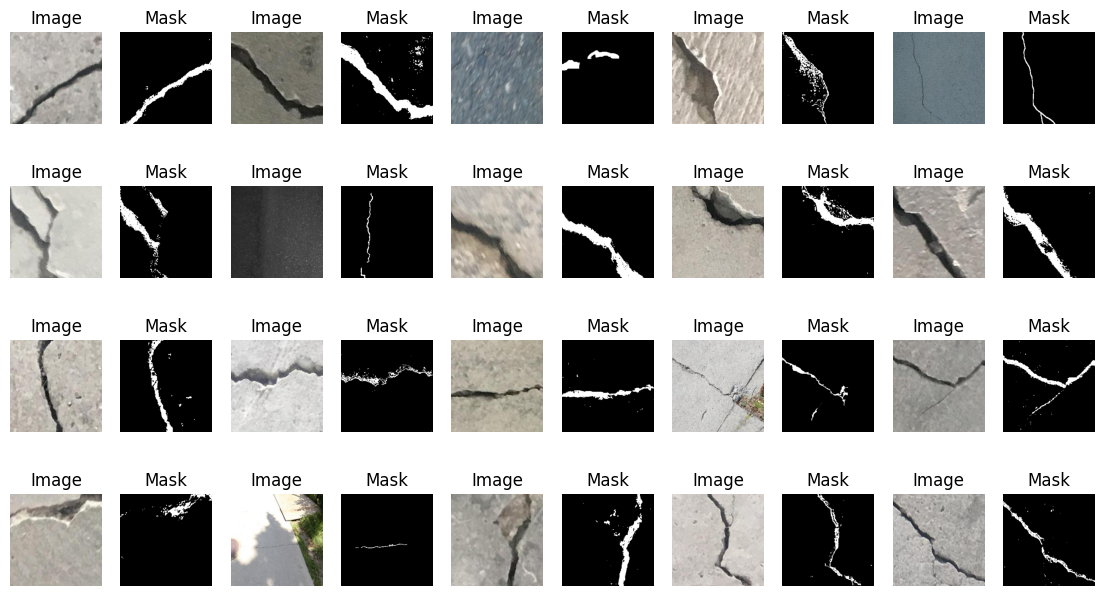

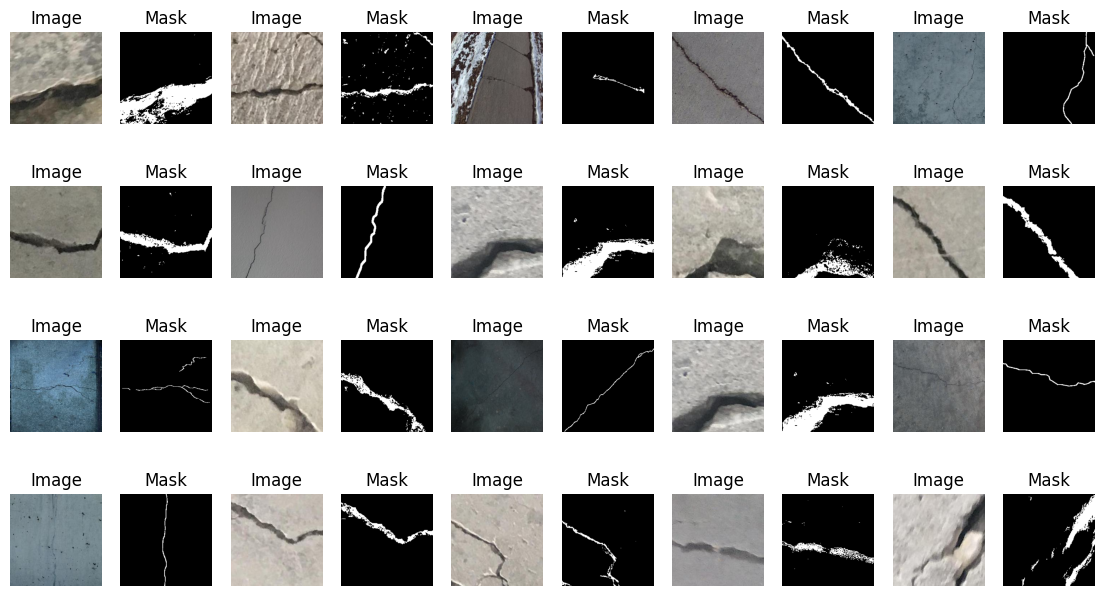

In [229]:
# Generate a batch of images and masks from the train_generator
imgs, masks = next(train_generator)
# Plot the images and masks
plotImages(imgs, masks)
# Generate a batch of images and masks from the val_generation
val_imgs, val_masks = next(val_generator)
# Plot the images and masks
plotImages(val_imgs, val_masks)

Final Training and Val Loss changed by: -0.003 , -0.008

Training Recall Score changed by: 0.014
Training F1 Score changed by: -0.003
Training IoU Score changed by: 0.008
Val Recall Score changed by: 0.042
Val F1 Score changed by: -0.008
Val IoU Score changed by: 0.016
Number of epochs for Run # 20: 5
Comments for Run #20: Sample: 0.1, Batch: 20, bin_crossentropy(0.9,1.1), Leaky Relu (0.375), he_normal, adam=0.0001, 6 layers, kernel(3,3)



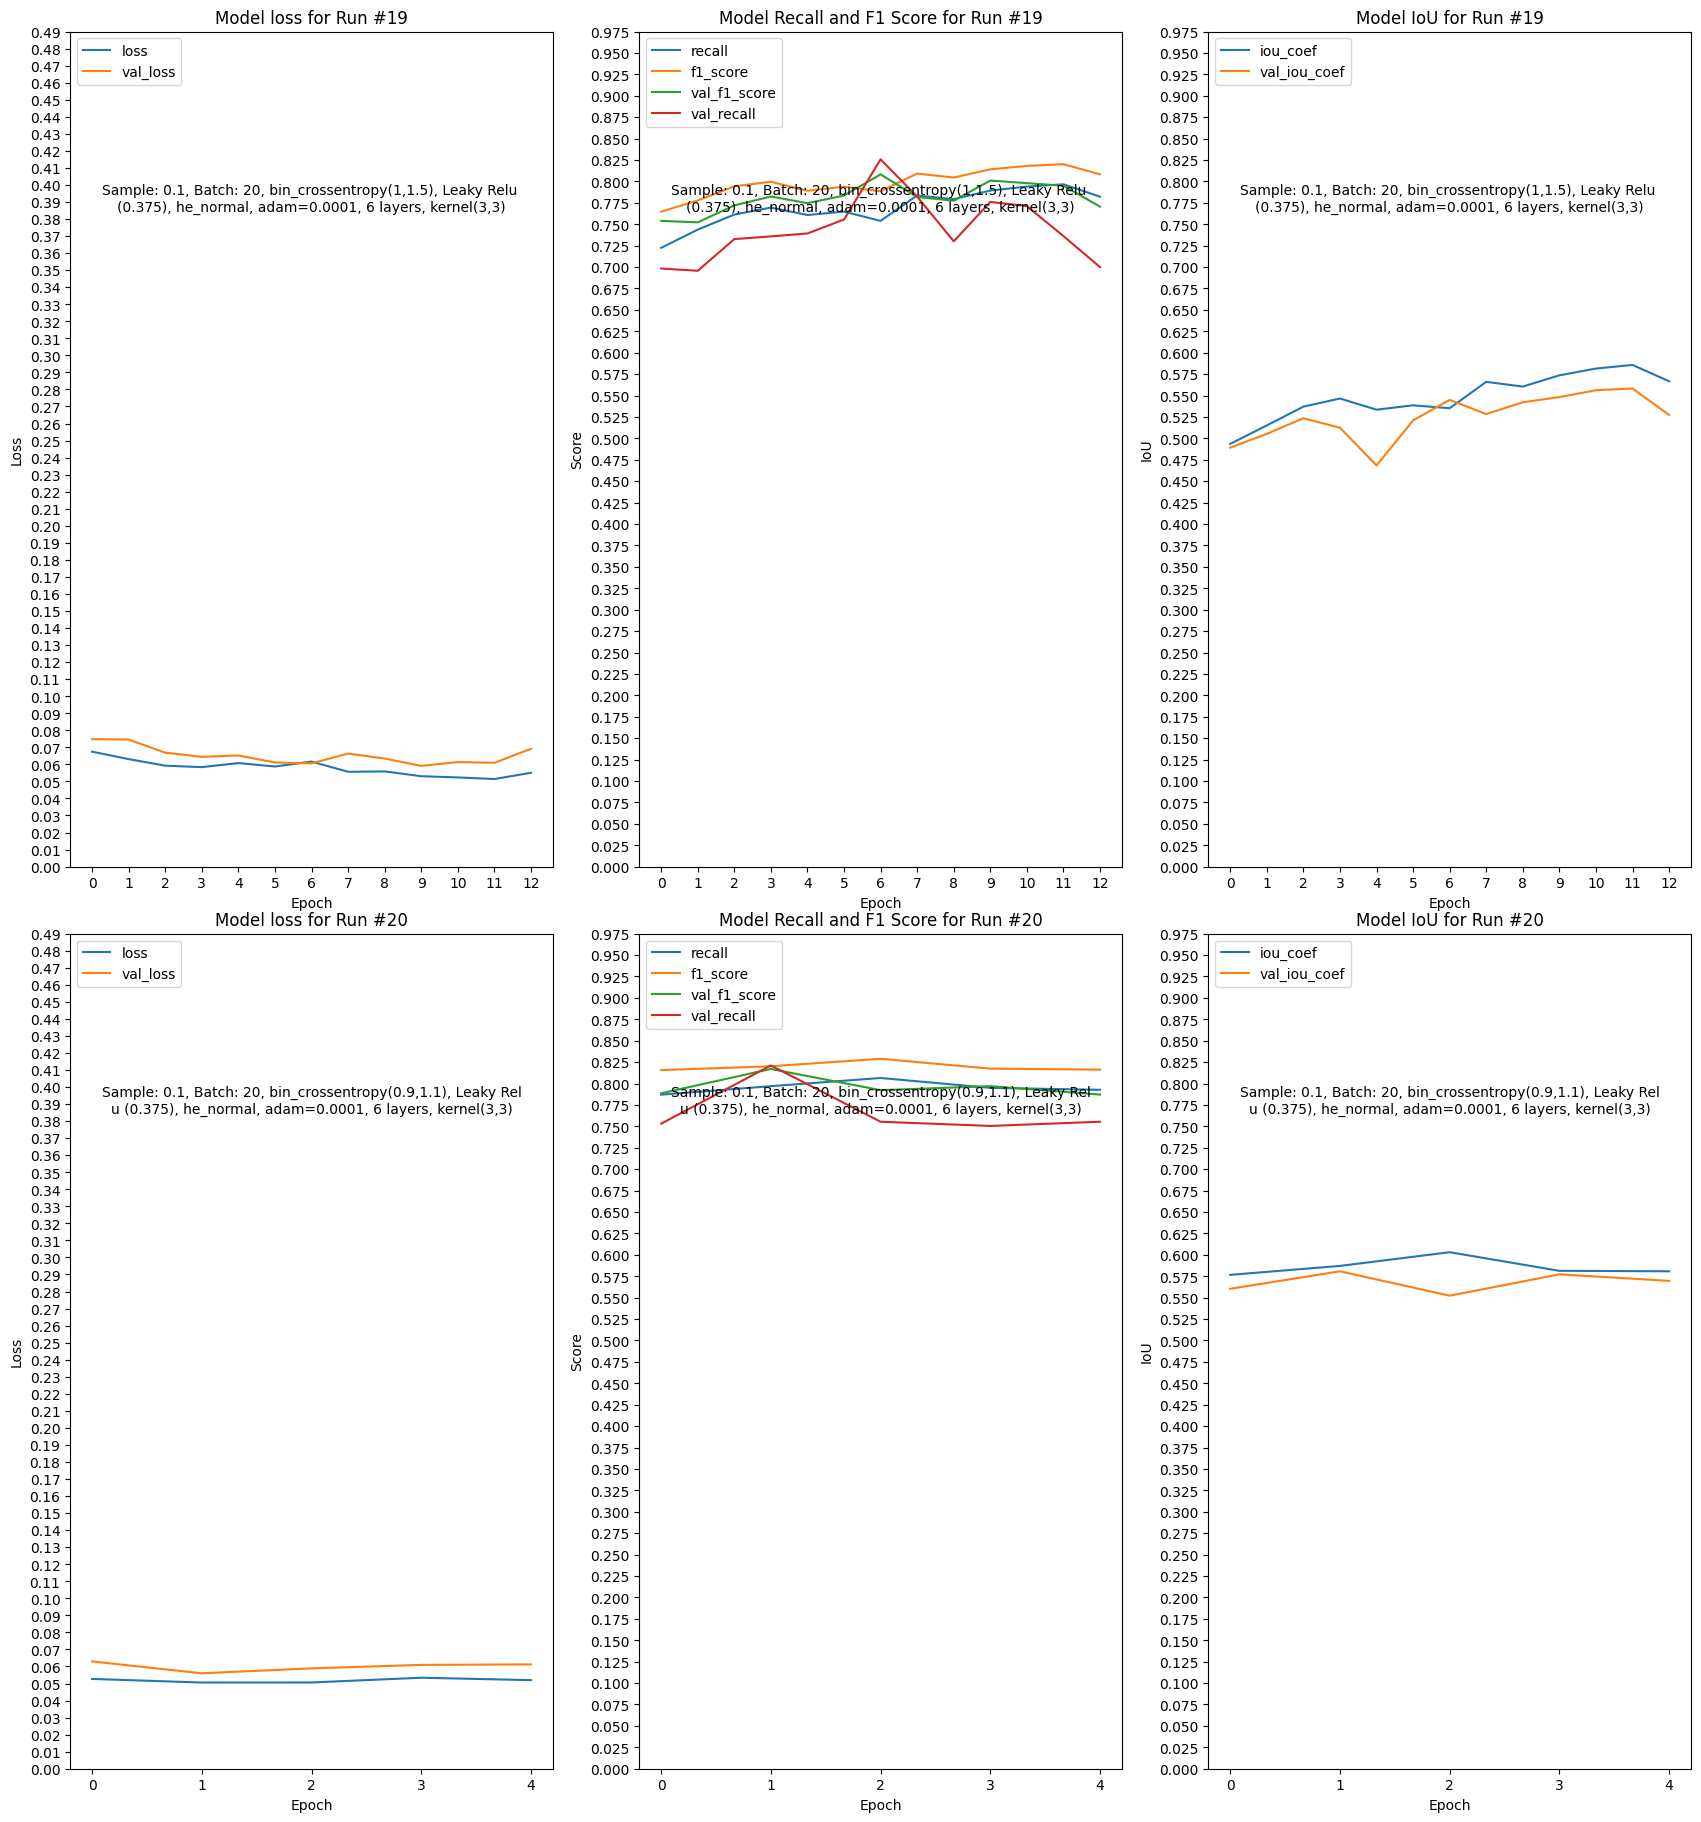

In [401]:
# Note df_history was accidently made into an int and only final values were stored in df_history_final. 
# Therefore only graphs of Run # 13 can be plotted beolow

# This is used iteratively to see if the changes made were improvements or not
plot_results(count -1,count)

### Loss, IoU, and F1 Per run

In [619]:
# Save tuning history:
df_history.to_csv(os.path.join(Save_Path,'df_history.csv'),index=False)

# showing last 4
df_history_final.tail(4)

Run #      loss  f1_score  iou_coef    recall  precision  accuracy   
17     18  0.062291  0.781469  0.519802  0.748072   0.831792  0.978003  \
18     19  0.055067  0.808284  0.566680  0.782167   0.847521  0.980129   
19     20  0.051980  0.816222  0.580749  0.792636   0.852715  0.981036   
20     21  0.030403  0.883036  0.716128  0.874691   0.900731  0.987564   

    val_loss  val_f1_score  val_iou_coef  val_recall  val_precision   
17  0.063176      0.779645      0.506460    0.720693       0.852513  \
18  0.069133      0.770563      0.527320    0.699972       0.856120   
19  0.061213      0.787050      0.569577    0.755367       0.835308   
20  0.037069      0.869015      0.705202    0.865964       0.881459   

    val_accuracy  
17      0.977245  
18      0.975443  
19      0.978619  
20      0.986327

Run #            20.000000
loss              0.051980
f1_score          0.816222
iou_coef          0.580749
recall            0.792636
precision         0.852715
accuracy          0.981036
val_loss          0.061213
val_f1_score      0.787050
val_iou_coef      0.569577
val_recall        0.755367
val_precision     0.835308
val_accuracy      0.978619
Name: 19, dtype: float64


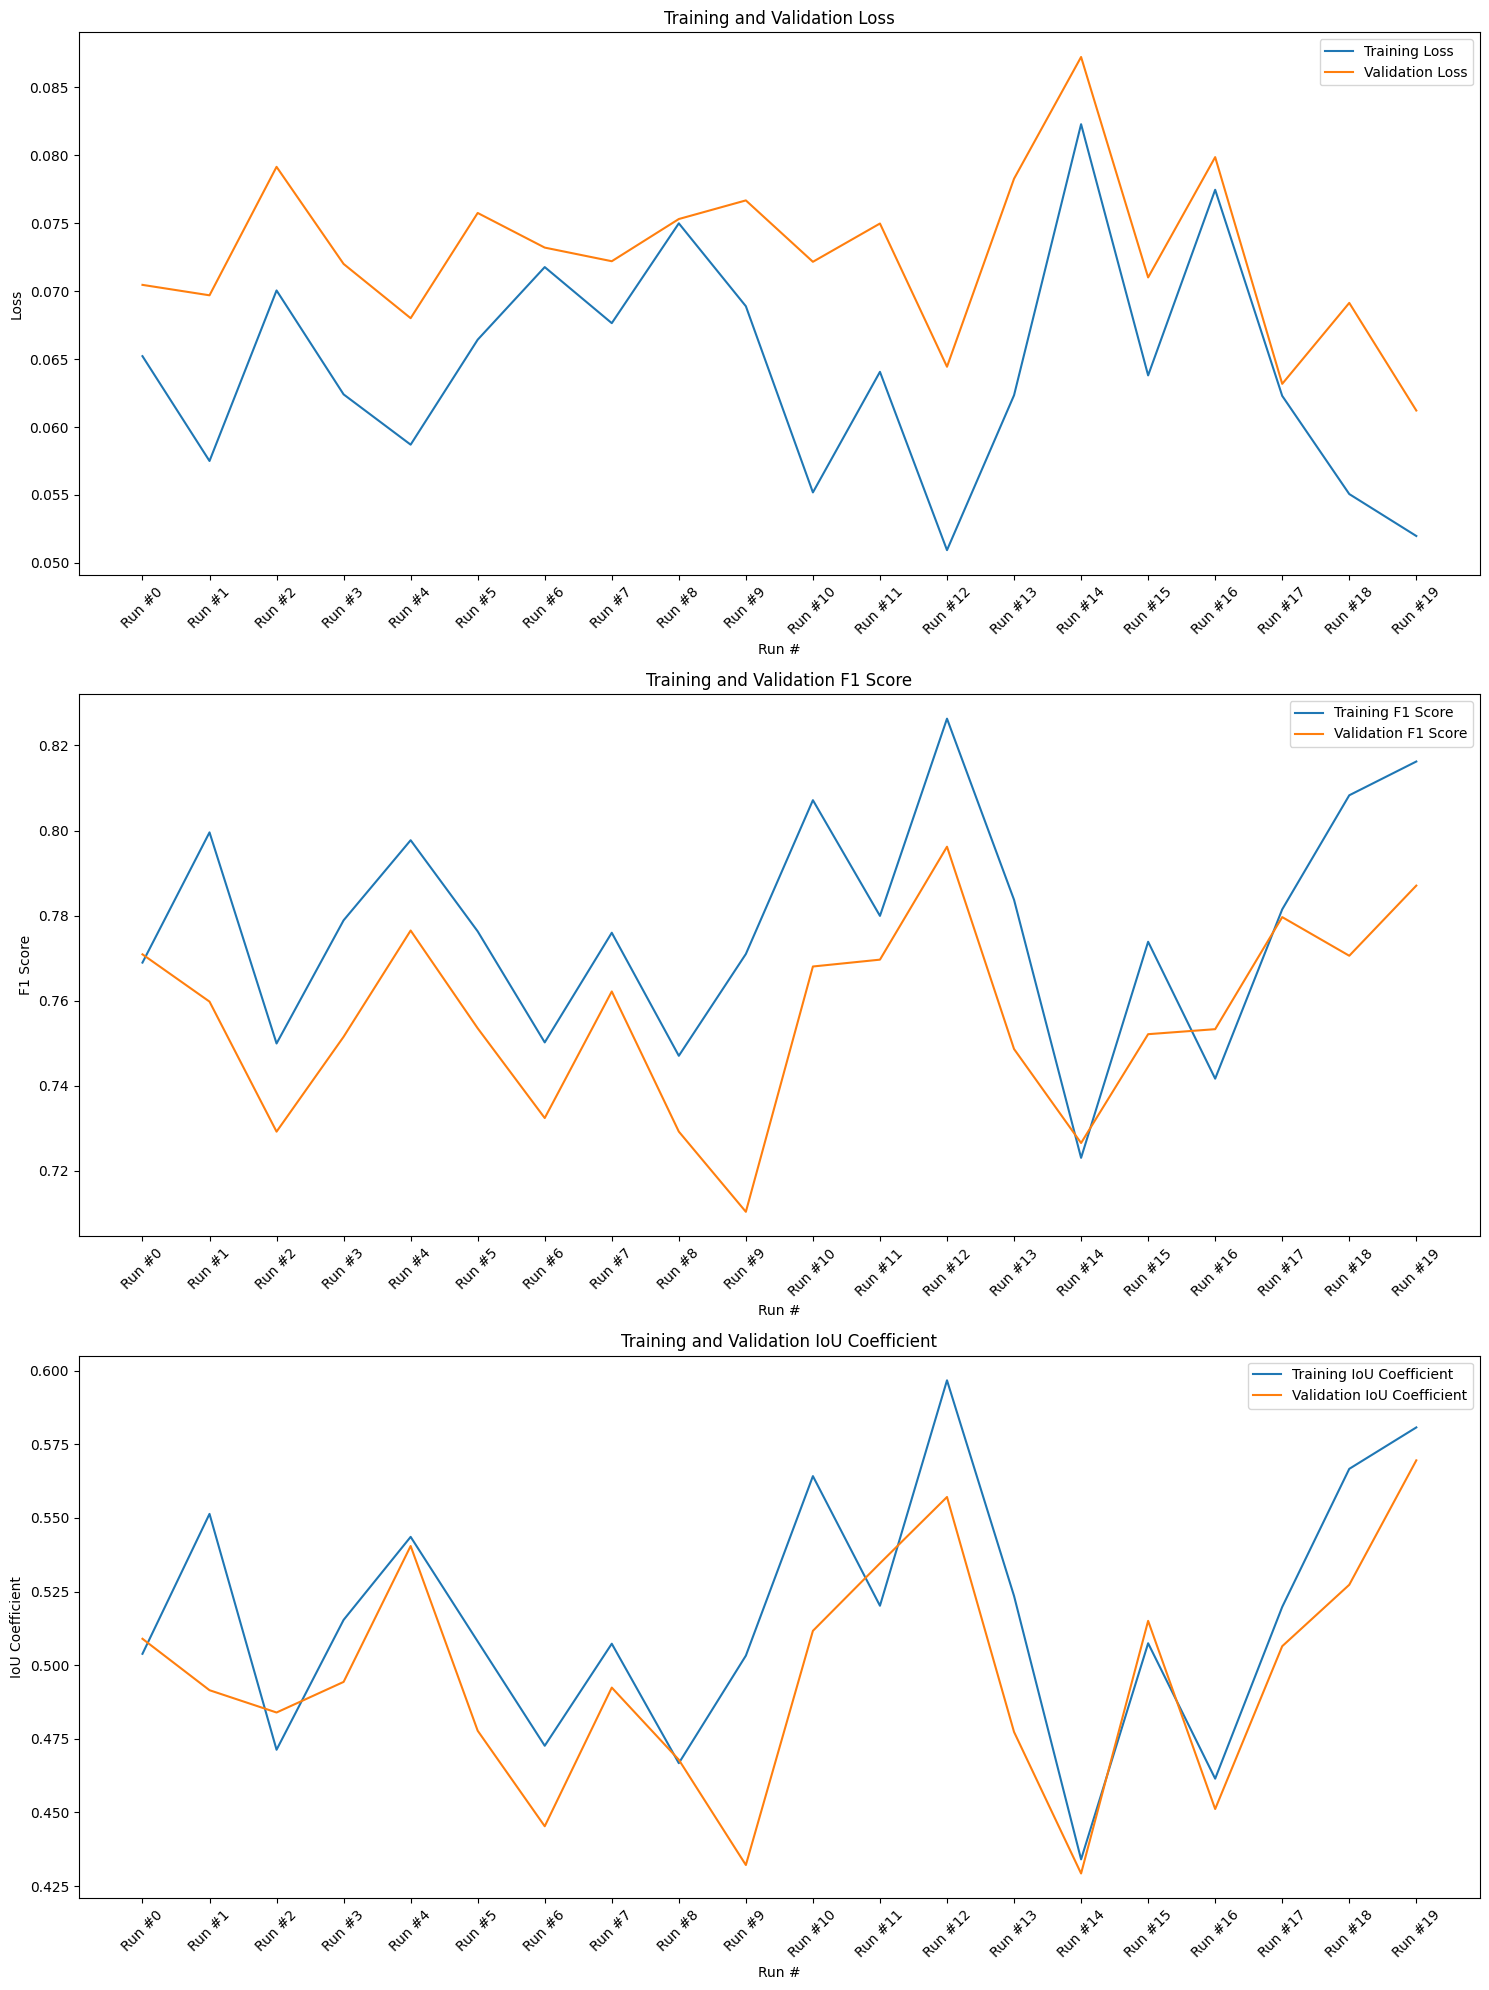

Run #      loss  f1_score  iou_coef    recall  precision  accuracy   
16     17  0.077457  0.741670  0.461480  0.694596   0.806546  0.973012  \
17     18  0.062291  0.781469  0.519802  0.748072   0.831792  0.978003   
18     19  0.055067  0.808284  0.566680  0.782167   0.847521  0.980129   
19     20  0.051980  0.816222  0.580749  0.792636   0.852715  0.981036   

    val_loss  val_f1_score  val_iou_coef  val_recall  val_precision   
16  0.079861      0.753303      0.451174    0.755816       0.755808  \
17  0.063176      0.779645      0.506460    0.720693       0.852513   
18  0.069133      0.770563      0.527320    0.699972       0.856120   
19  0.061213      0.787050      0.569577    0.755367       0.835308   

    val_accuracy  
16      0.971287  
17      0.977245  
18      0.975443  
19      0.978619

In [428]:
# print run with the lowest final validation loss
min_val_loss_row = df_history_final.loc[df_history_final['val_loss'].idxmin()]
print(min_val_loss_row)

# Plot results per run #
plot_final_results(df_history_final)

# print dataframe with last results per run
df_history_final.tail(4)

### Documentation

**Layers:**

- Switching from 7 layers to 6 layers loss improved. (Run 1 to 2)
- Switching from 6 layers to 5 increased loss.  (Run 2 to 3)

Conclusion: 6 layers is optimal

**Kernels:**

- Switching from 5,5 to 3,3 improved loss. (Run 4 to 5)

Conclusion: 3,3 kernels are optimal

**Kernel Initializer**

- Switching to he_uniform increased loss. (Run 5 to 6)

Conclusion: he_normal > he_uniform

**Activation Function**

- Switching from ReLu to Leaky ReLu (0.01) improved loss. (Run 6 to 7)
- Leaky ReLu (0.1) improved loss (Run 7 to 8)
- Leaky ReLu (0.5) increased loss. (Run 8 to 9)
- Switching to 0.25 increased loss (Run 9 to 10)
- Switching to 0.375 improves loss. Best so far. (Run 10 to 11)
- Leaky ReLu switch Run 7 to 8 also included hu_normal switch. Therefore switched to regular ReLu and saw (Run 13 to 16 back and forth. Leaky Relu 0.375 is still optimal)

Conclusion: Leaky ReLu with coefficient 0.375 is optimal

**Optimizer:**

- Switched to RMSprop and loss increased (Run 11 to 12)
- Switched to SGD with momentum 0.9 and loss increased even more. Least effective. (Run 12 to 13)

Conclusion: Adam is optimal


**Loss Function Weights:**

- Increased weight of positive from 1 to 1.1. Improved loss (Run 17 to 18)
- Increased weight of positive to 1.5. (Run 18 to 19). Overfitting problem.
- Reverted positive weight to 1.1, decreased negative weight to 0.9. Seems like beginning to overfit. Wiil not explore anymore (Run 19 to 20)

Conclusion: negative weight = 0.9, postive weight = 1.1 is optimal

**The final training model is:** 
- Sample: 0.1, 
- Batch: 20, 
- bin_crossentropy(0.9,1.1), 
- Leaky Relu (0.375), 
- he_normal, 
- adam=0.0001, 
- 6 layers, 
- kernel(3,3)

## Training Model

Note: 0.99 sample was used due to train-val-split code limitations for notebook simplicity

In [434]:
"""
Note that save file location for "Early Stopping" (to stop unecessary epoch iterations) is noted in the function 'run_model'
"""

# Parameters
batch_size = 10 # number of samples that are processed before model is updated
epochs = 70 # maximum number of complete passes through training dataset
patience = 3 # number of epochs required to stop training if val_loss doesn't improve

# dataframes required:
df_train_selected = df_256_positive_train
df_val_selected = df_256_positive_val
df_test_selected = df_256_positive_test

# record changes made to dictionary:
caption = 'Sample: 0.1, Batch: 20, bin_crossentropy(0.9,1.1), Leaky Relu (0.375), he_normal, adam=0.0001, 6 layers, kernel(3,3)'

# Run model
run_model(df_train_selected, df_val_selected, df_test_selected, batch_size, epochs, patience, caption)

# store training results
df_results = pd.DataFrame(unet.history.history).copy()

Checkpoint Directory: C:\Users\sepeh\OneDrive\Downloads
Epoch 1/70
2334/2334 [==============================] - 437s 187ms/step - loss: 0.0592 - f1_score: 0.7918 - iou_coef: 0.5405 - recall_22: 0.7600 - precision_22: 0.8402 - accuracy: 0.9788 - val_loss: 0.0530 - val_f1_score: 0.7978 - val_iou_coef: 0.5597 - val_recall_22: 0.7448 - val_precision_22: 0.8771 - val_accuracy: 0.9806
Epoch 2/70
2334/2334 [==============================] - 418s 179ms/step - loss: 0.0521 - f1_score: 0.8104 - iou_coef: 0.5745 - recall_22: 0.7852 - precision_22: 0.8522 - accuracy: 0.9809 - val_loss: 0.0489 - val_f1_score: 0.8249 - val_iou_coef: 0.6104 - val_recall_22: 0.8203 - val_precision_22: 0.8415 - val_accuracy: 0.9819
Epoch 3/70
2334/2334 [==============================] - 425s 182ms/step - loss: 0.0509 - f1_score: 0.8168 - iou_coef: 0.5863 - recall_22: 0.7923 - precision_22: 0.8556 - accuracy: 0.9811 - val_loss: 0.0478 - val_f1_score: 0.8132 - val_iou_coef: 0.5901 - val_recall_22: 0.7532 - val_precision_

NameError: name 'df_history_new' is not defined

In [513]:
df_results

loss  f1_score  iou_coef  recall_22  precision_22  accuracy  val_loss   
0   0.059203  0.791768  0.540485   0.759970      0.840171  0.978805  0.052979  \
1   0.052139  0.810363  0.574473   0.785234      0.852172  0.980851  0.048852   
2   0.050904  0.816836  0.586322   0.792298      0.855617  0.981072  0.047826   
3   0.047514  0.826050  0.603608   0.805909      0.862808  0.982234  0.045469   
4   0.045053  0.835050  0.620112   0.814877      0.867767  0.982869  0.044444   
5   0.042950  0.840398  0.630048   0.820908      0.873094  0.983626  0.041943   
6   0.041588  0.845023  0.640309   0.826075      0.878040  0.984061  0.041799   
7   0.040216  0.850649  0.650048   0.832490      0.880423  0.984503  0.044138   
8   0.039621  0.850598  0.651383   0.832134      0.881407  0.984624  0.039746   
9   0.037393  0.859434  0.668413   0.843446      0.886760  0.985289  0.041833   
10  0.037337  0.856825  0.664099   0.840304      0.885699  0.985333  0.038629   
11  0.036211  0.862045  0.674182   0.847014      0.888533  0.985668  0.038608   
12  0.034901  0.865528  0.680560   0.851701      0.890069  0.986091  0.041410   
13  0.034352  0.867175  0.683956   0.854418      0.891177  0.986261  0.038352   
14  0.034387  0.867792  0.685705   0.854959      0.891917  0.986247  0.036161   
15  0.032660  0.873334  0.695952   0.860719      0.895096  0.986854  0.038333   
16  0.032642  0.873377  0.696671   0.862689      0.895154  0.986813  0.038664   
17  0.031946  0.876860  0.703649   0.866313      0.897679  0.987066  0.035617   
18  0.031226  0.879290  0.708386   0.868756      0.898551  0.987296  0.038509   
19  0.030315  0.881640  0.713019   0.872880      0.900033  0.987643  0.037910   
20  0.030403  0.883036  0.716128   0.874691      0.900731  0.987564  0.037069   

    val_f1_score  val_iou_coef  val_recall_22  val_precision_22  val_accuracy  
0       0.797823      0.559737       0.744830          0.877146      0.980562  
1       0.824895      0.610449       0.820294          0.841487      0.981942  
2       0.813165      0.590074       0.753176          0.899170      0.981823  
3       0.837988      0.639465       0.824143          0.861098      0.982659  
4       0.840155      0.639267       0.842007          0.850532      0.983214  
5       0.846378      0.650331       0.844596          0.860674      0.983976  
6       0.843301      0.648662       0.812116          0.889442      0.984266  
7       0.842885      0.646462       0.871699          0.828188      0.983024  
8       0.857821      0.677829       0.867049          0.857782      0.984652  
9       0.853822      0.669588       0.877781          0.841645      0.984188  
10      0.857764      0.672269       0.838648          0.887322      0.985115  
11      0.850855      0.661159       0.820783          0.898910      0.985355  
12      0.855277      0.665998       0.859589          0.862600      0.984800  
13      0.865799      0.694330       0.872476          0.867445      0.985503  
14      0.866318      0.691487       0.862388          0.879610      0.986129  
15      0.863589      0.692719       0.860094          0.876135      0.985803  
16      0.862037      0.683343       0.858980          0.874792      0.985364  
17      0.867738      0.697148       0.868961          0.876300      0.986294  
18      0.865003      0.699143       0.874441          0.864406      0.985521  
19      0.865529      0.694518       0.843018          0.896158      0.985673  
20      0.869015      0.705202       0.865964          0.881459      0.986327

Final results:


loss                0.030403
f1_score            0.883036
iou_coef            0.716128
recall_22           0.874691
precision_22        0.900731
accuracy            0.987564
val_loss            0.037069
val_f1_score        0.869015
val_iou_coef        0.705202
val_recall_22       0.865964
val_precision_22    0.881459
val_accuracy        0.986327
Name: 20, dtype: float64

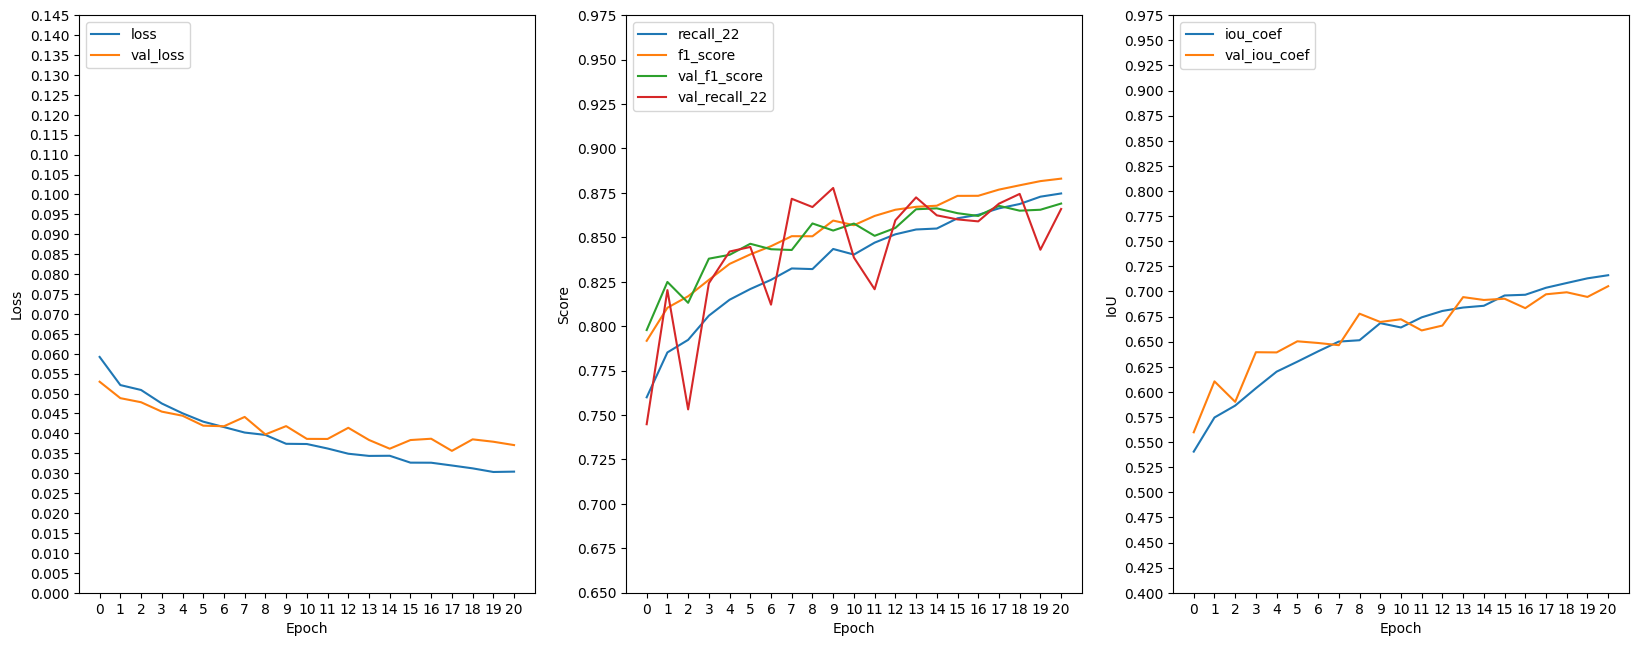

In [511]:
plt.figure(figsize = (20,7.5))

# List of columns to plot
columns_to_plot = [['loss', 'val_loss'], 
                   ['recall_22','f1_score','val_f1_score', 'val_recall_22'], 
                   ['iou_coef', 'val_iou_coef']]

# list of y labels to plot
y_labels_to_plot = ['Loss', 'Score', 'IoU']

# Set x-ticks to represent the number of epochs
num_of_epochs = df_results.shape[0]
            
for i in range(1,4):
   
   # Plot columns_to_plot
   y = range(num_of_epochs)
   x = df_results[columns_to_plot[i-1]]
   
   plt.subplot(1,3,i)
   plt.plot(df_results[columns_to_plot[i-1]])
   plt.xlabel('Epoch')
   plt.ylabel(y_labels_to_plot[i-1])
   plt.legend(x,loc= 'upper left')
   plt.xticks(range(0,num_of_epochs))
   
            
            
   if i == 1:
         # set yticks and values shown
         plt.yticks(np.arange(0, 0.15, 0.005))
        
   if i == 2:
         # set yticks and values shown
         plt.yticks(np.arange(0.65, 1, 0.025))                   
            
   if i == 3:
         # set yticks and values shown
         plt.yticks(np.arange(0.4, 1, 0.025))
         
print(f'Final results:')
df_results.iloc[-1,:]

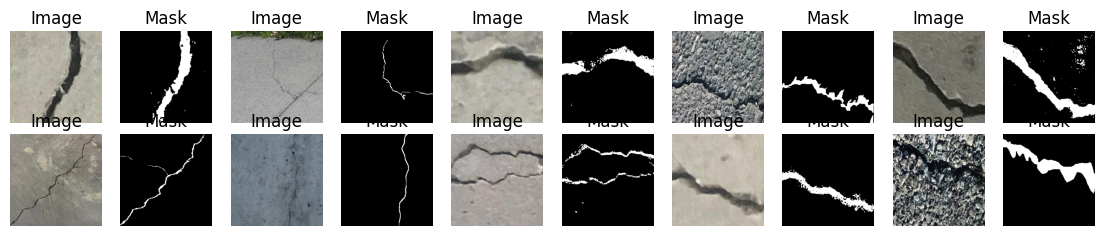

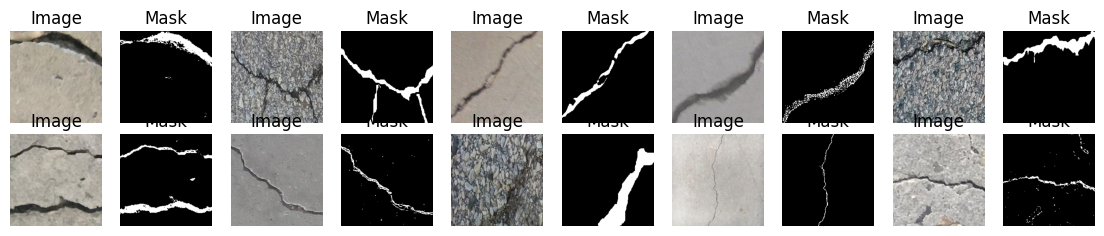

In [469]:
# Generate a batch of images and masks from the train_generator
imgs, masks = next(train_generator)
# Plot the images and masks
plotImages(imgs, masks)
# Generate a batch of images and masks from the val_generation
val_imgs, val_masks = next(val_generator)
# Plot the images and masks
plotImages(val_imgs, val_masks)

## Evaluating Model

In [519]:
#Test the U-Net Model
def evaluate_model(df_test_selected, batch_size = 10):
   
   # Create the data generators
   test_generator = create_data_generator(df_test_selected, batch_size, shuffle = False)

   # Evaluate the model on the test set
   scores = unet.evaluate(test_generator, steps=len(df_test_selected) // batch_size)
   return scores


# Parameters
batch_size = 10 # number of samples that are processed before model is updated

# dataframes required
df_test_selected = df_256_positive_test.reset_index(drop=True)

# Run model
evaluate_model(df_test_selected, batch_size)

484/484 [==============================] - 42s 85ms/step - loss: 0.0377 - f1_score: 0.8651 - iou_coef: 0.6930 - recall_22: 0.8639 - precision_22: 0.8771 - accuracy: 0.9857


[0.03773054480552673,
 0.8651278614997864,
 0.693036675453186,
 0.8638708591461182,
 0.8771198987960815,
 0.985740065574646]

In [565]:
# Load the ground truth masks
true_masks = []
for index, row in df_test_selected.iterrows():
    mask_path = row['Mask_File_Path']
    mask = load_mask(mask_path)  # Implement a function to load the mask from file
    true_masks.append(mask)

# Load the predicted masks
predicted_masks = unet.predict(test_generator)  # Assuming you have the test generator set up correctly

# Reshape the masks to a 1D array
true_masks = np.concatenate(true_masks)
predicted_masks = np.concatenate(predicted_masks)

# Flatten the masks to 1D arrays
true_masks = true_masks.flatten()
predicted_masks = predicted_masks.flatten()

# Create the confusion matrix
confusion_mat = confusion_matrix(true_masks, predicted_masks)


Image_File_Path   
0     C:\Users\sepeh\OneDrive\Documents\Data\Concret...  \
1     C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
2     C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
3     C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
4     C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
...                                                 ...   
4842  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
4843  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
4844  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
4845  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
4846  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   

                                         Mask_File_Path  
0     C:\Users\sepeh\OneDrive\Documents\Data\Concret...  
1     C:\Users\sepeh\OneDrive\Documents\Data\Concret...  
2     C:\Users\sepeh\OneDrive\Documents\Data\Concret...  
3     C:\Users\sepeh\OneDrive\Documents\Data\Concret...  
4     C:\Users\sepeh\OneDrive\Documents\Data\Concret...  
...                                                 ...  
4842  C:\Users\sepeh\OneDrive\Documents\Data\Concret...  
4843  C:\Users\sepeh\OneDrive\Documents\Data\Concret...  
4844  C:\Users\sepeh\OneDrive\Documents\Data\Concret...  
4845  C:\Users\sepeh\OneDrive\Documents\Data\Concret...  
4846  C:\Users\sepeh\OneDrive\Documents\Data\Concret...  

[4847 rows x 2 columns]

1/1 [==============================] - 0s 29ms/step


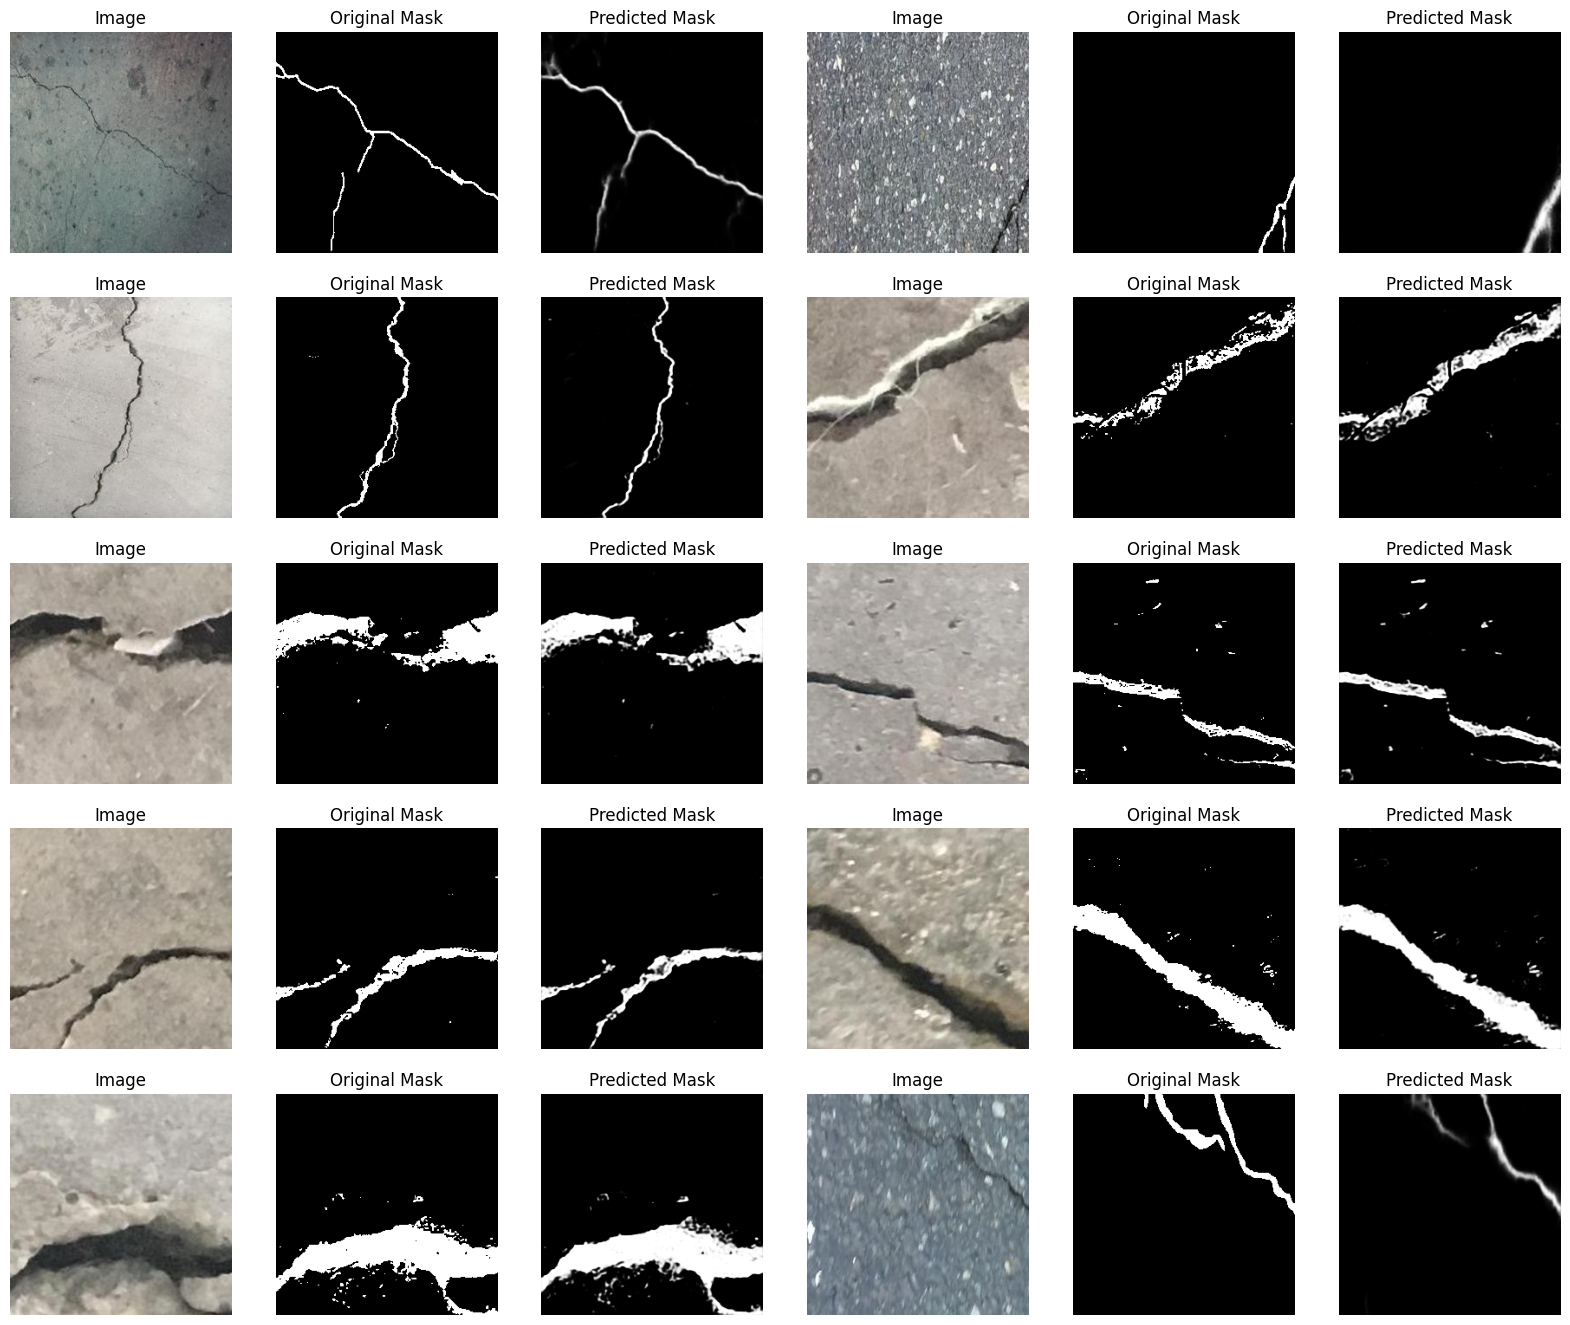

In [561]:
## Plots predicted images   
def plotImages(images_arr, original_masks_arr, predicted_masks_arr, width = 20, height = 20, hspace = -0.96):
    num_images = len(images_arr) * 3  # Each group consists of 3 images
    num_cols = 6  # Each group will occupy 3 columns (one for image, one for original mask, one for predicted mask)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate rows based on images
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(width, height*num_rows), sharex=True, sharey=True)
    
    axes = axes.ravel()  # Flatten axes for easy indexing
    
    for i in range(len(images_arr)):
        axes[3*i].imshow(images_arr[i])
        axes[3*i].axis('off')
        axes[3*i].set_title('Image')
        
        axes[3*i+1].imshow(original_masks_arr[i], cmap='gray')
        axes[3*i+1].axis('off')
        axes[3*i+1].set_title('Original Mask')
        
        axes[3*i+2].imshow(predicted_masks_arr[i], cmap='gray')
        axes[3*i+2].axis('off')
        axes[3*i+2].set_title('Predicted Mask')
        
    # Turn off axes for remaining empty subplots
    for j in range(num_images, num_rows*num_cols):
        fig.delaxes(axes[j])
        
    # Adjust the spacing between rows
    plt.subplots_adjust(hspace= hspace)  

# Generate a batch of images and masks from the test_generator
imgs, masks = next(test_generator)

# Generate predictions
predicted_masks = unet.predict(imgs)

# Plot the images, original masks, and predicted masks
plotImages(imgs, masks, predicted_masks)


In [621]:
# # Generate a batch of images and masks from the test_generator
# imgs, masks = next(test_generator)

# # Generate predictions
# predicted_masks = unet.predict(imgs)

# # Convert masks and predicted_masks to integer arrays (if they are not already)
# masks = masks.astype(int)
# predicted_masks = predicted_masks.astype(int)

# # Create confusion matrix and normalize it over predicted (columns)
# result = confusion_matrix(masks.flatten(), predicted_masks.flatten(), normalize='pred')

# # Convert the confusion matrix to a DataFrame for better visualization
# cm_df = pd.DataFrame(result, index=['Ground Truth 0', 'Ground Truth 1'], columns=['Predicted 0', 'Predicted 1'])

# # Create a custom colormap to emphasize the minority class (1)
# cmap = sns.diverging_palette(220, 20, as_cmap=True)

# # Plot the confusion matrix as a heatmap with the custom colormap
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_df, annot=True, cmap=cmap, fmt='.2f', cbar=False)

# # Customize the plot
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('Ground Truth Label')

# # Show the plot
# plt.show()

In [612]:
# Save Model
unet.save(os.path.join(HOME, 'models', 'UNET_Crack_Segmentation_20230514.hdf5'))
print(f"SUCCESS! Model saved at: {os.path.join(HOME, 'models', 'UNET_Model_20230514.hdf5')}")

SUCCESS! Model saved at: \\sepehrnas\Thick Volume\CAREER\SEPEHR\EDUCATION\Brainstation\Data Science\Deliverables\Capstone\segment_anything\models\UNET_Model_20230514.hdf5


## Retraining with Validation (Will be done another date)

Now that the results are confirmed viable, the model will be retrained again, but this time validation will be included because it has already been 'seen' by the model due to adjusting the parameters based on its results. By doing this, the model will have even more data to improve its performance.

In [ ]:
# """
# Note that save file location for "Early Stopping" (to stop unecessary epoch iterations) is noted in the function 'run_model'
# """

# def run_model_final(df_train_selected, df_val_selected, df_test_selected, batch_size = 32, epochs = 15, patience = 3):
          
#     # Parameters
#     batch_size = batch_size
#     df_train = df_train_selected.copy().reset_index(drop=True)

#     # Create the data generator
#     train_generator = create_data_generator(df_train, batch_size, shuffle = True)

#     # Model Checkpoint directory path
#     # checkpoint_filepath = os.path.join(Data_Home, 'Model_Checkpoints', 'Checkpoint')
#     checkpoint_filepath = r'C:\Users\sepeh\OneDrive\Downloads'

#     # Create if it doesn't exist
#     if not os.path.exists(checkpoint_filepath):
#         os.makedirs(checkpoint_filepath)

#     print(f'Checkpoint Directory: {checkpoint_filepath}')

#     # # Initialize the Model Checkpoint callback
#     model_checkpoint_callback = ModelCheckpoint(
#         filepath=checkpoint_filepath,
#         save_weights_only=True,
#         monitor='val_loss', # monitors validation loss
#         mode='min',
#         save_best_only=True)

#     # Initialize the Early Stopping callback
#     early_stopping_callback = EarlyStopping(
#         monitor='val_loss', # monitors validation loss
#         mode='min',
#         patience=patience, # training will be stopped after set# of epochs (patience) if val_loss doesn't improve
#         restore_best_weights=True)

#     """ 

#     Model.fit

#     """
#     # Train the U-Net model
#     history = unet.fit(train_generator,
#                   #   validation_data=val_generator,
#                     steps_per_epoch=len(df_train) // batch_size,
#                     validation_steps=len(df_val) // batch_size,
#                     epochs=epochs,
#                   #   callbacks=[model_checkpoint_callback, early_stopping_callback]
#                     ) 

# # Parameters
# batch_size = 15 # number of samples that are processed before model is updated
# epochs = 100 # maximum number of complete passes through training dataset
# patience = 3 # number of epochs required to stop training if val_loss doesn't improve

# # Creating larger training set
# df_256_positive_train_final = pd.Concatenate([df_256_positive_train, df_256_positive_val], axis = 0)
# df_256_positive_train_final.reset_index(drop=True)

# # dataframes required:
# df_train_selected = df_256_positive_train_final
# df_val_selected = df_256_positive_val
# df_test_selected = df_256_positive_test

# # Run model
# run_model_final(df_train_selected, df_val_selected, df_test_selected, batch_size, epochs, patience)

## Conclusion

The training of the UNET model was a success. The final evaluation was:
- Loss: 0.0377
- F1 Score: 0.8651
- IoU Coefficient: 0.6930
- Recall: 0.8639
- Precision: 0.8771

The dataset was imbalanced my nature, and recall was focused on to ensure cracks were not missed. 0.8639 recall is a good score for this inital training. The next step is to train this model with both validiation and train set and then to test it again. Images have been taken from concrete structures outdoors and they will be manually masked to increase the dataset size and versatility. Now that the model has been saved, it will be fed into 

